In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# Run below to list all files under the input directory:
    # yelp_academic_dataset_review.json, yelp_academic_dataset_checkin.json, yelp_academic_dataset_business.json, yelp_academic_dataset_tip.json, and elp_academic_dataset_user.json

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/yelp-dataset/Dataset_User_Agreement.pdf
/kaggle/input/yelp-dataset/yelp_academic_dataset_review.json
/kaggle/input/yelp-dataset/yelp_academic_dataset_checkin.json
/kaggle/input/yelp-dataset/yelp_academic_dataset_business.json
/kaggle/input/yelp-dataset/yelp_academic_dataset_tip.json
/kaggle/input/yelp-dataset/yelp_academic_dataset_user.json


In [3]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf


# Plot style
sns.set(style='whitegrid')

In [4]:
# Reusable functions for common tasks - data loading, cleaning, and visualization

# Preprocesses text
def clean_text(text):
    """Clean and preprocess review text."""
    text = text.lower()   
    text = re.sub(r'[^\w\s]', '', text)  # removes punctuation
    text = re.sub(r'\d+', '', text)  # removes numbers
    return text

# Plots rating distribution
def plot_rating_distribution(df, column='stars'):
    """Plot the distribution of star ratings."""
    plt.figure(figsize=(8, 6))
    sns.countplot(x=column, data=df, palette="viridis")
    plt.title("Distribution of Star Ratings")
    plt.xlabel("Stars")
    plt.ylabel("Frequency")
    plt.show()

# Loads and preprocesses review data
def load_and_preprocess_reviews(file_path):
    """Load, clean, and preprocess review data for analysis."""
    df = load_data(file_path)
    df['cleaned_text'] = df['text'].apply(clean_text)
    return df

# Datasets are really large (went over Kaggle usage limit trying to load), so need to load in chunks 
    # coluns = list of columns to keep 
    # chunk_size = number of rows per chunk
def load_data_in_chunks(file_path, columns=None, chunk_size=10000):
    """
    Load a large JSON file in chunks, selecting only specified columns.
    
    Returns:
    - DataFrame: Concatenated DataFrame containing selected columns.
    """
    data_chunks = []  # To store individual chunks

    # Load file in chunks
    for chunk in pd.read_json(file_path, lines=True, chunksize=chunk_size):
        # Select only specified columns
        if columns:
            chunk = chunk[columns]
        data_chunks.append(chunk)
    
    # Concatenate chunks into a single DataFrame
    return pd.concat(data_chunks, ignore_index=True)

In [5]:
# Paths to each Yelp dataset file
review_file = '/kaggle/input/yelp-dataset/yelp_academic_dataset_review.json'
business_file = '/kaggle/input/yelp-dataset/yelp_academic_dataset_business.json'

# Only selecting columns that relevant to analysis to reduce memory usage
review_columns = ['review_id', 'text', 'stars', 'business_id']
business_columns = ['business_id', 'name', 'categories', 'stars']

# Load reviews and businesses datasets
reviews_df = load_data_in_chunks(review_file, columns=review_columns)
business_df = load_data_in_chunks(business_file, columns=business_columns)

# Display the first few rows of each DataFrame
print("Reviews DataFrame:")
print(reviews_df.head())

print("\nBusiness DataFrame:")
print(business_df.head())


Reviews DataFrame:
                review_id                                               text  \
0  KU_O5udG6zpxOg-VcAEodg  If you decide to eat here, just be aware it is...   
1  BiTunyQ73aT9WBnpR9DZGw  I've taken a lot of spin classes over the year...   
2  saUsX_uimxRlCVr67Z4Jig  Family diner. Had the buffet. Eclectic assortm...   
3  AqPFMleE6RsU23_auESxiA  Wow!  Yummy, different,  delicious.   Our favo...   
4  Sx8TMOWLNuJBWer-0pcmoA  Cute interior and owner (?) gave us tour of up...   

   stars             business_id  
0      3  XQfwVwDr-v0ZS3_CbbE5Xw  
1      5  7ATYjTIgM3jUlt4UM3IypQ  
2      3  YjUWPpI6HXG530lwP-fb2A  
3      5  kxX2SOes4o-D3ZQBkiMRfA  
4      4  e4Vwtrqf-wpJfwesgvdgxQ  

Business DataFrame:
              business_id                      name  \
0  Pns2l4eNsfO8kk83dixA6A  Abby Rappoport, LAC, CMQ   
1  mpf3x-BjTdTEA3yCZrAYPw             The UPS Store   
2  tUFrWirKiKi_TAnsVWINQQ                    Target   
3  MTSW4McQd7CbVtyjqoe9mw        St Honore Pastri

In [6]:
# Merging the filtered data results in a combined DataFrame that only contains restaurant reviews
    # Manageable within Kaggle’s memory constraints

# Filter for restaurants in the business dataset
restaurants_df = business_df[business_df['categories'].str.contains('Restaurants', na=False)]

# Merge the reviews and restaurants dataframes on the business_id
restaurant_reviews_df = pd.merge(reviews_df, restaurants_df[['business_id', 'name', 'categories', 'stars']], on='business_id', how='inner')

# Display the first few rows of the combined dataset
print("\nCombined Restaurant Reviews DataFrame:")
print(restaurant_reviews_df.head())



Combined Restaurant Reviews DataFrame:
                review_id                                               text  \
0  KU_O5udG6zpxOg-VcAEodg  If you decide to eat here, just be aware it is...   
1  saUsX_uimxRlCVr67Z4Jig  Family diner. Had the buffet. Eclectic assortm...   
2  AqPFMleE6RsU23_auESxiA  Wow!  Yummy, different,  delicious.   Our favo...   
3  Sx8TMOWLNuJBWer-0pcmoA  Cute interior and owner (?) gave us tour of up...   
4  JrIxlS1TzJ-iCu79ul40cQ  I am a long term frequent customer of this est...   

   stars_x             business_id                          name  \
0        3  XQfwVwDr-v0ZS3_CbbE5Xw  Turning Point of North Wales   
1        3  YjUWPpI6HXG530lwP-fb2A             Kettle Restaurant   
2        5  kxX2SOes4o-D3ZQBkiMRfA                         Zaika   
3        4  e4Vwtrqf-wpJfwesgvdgxQ                          Melt   
4        1  04UD14gamNjLY0IDYVhHJg                      Dmitri's   

                                          categories  stars_y  
0  Res

**Description of cells above:** Given the large size of the Yelp dataset, I took steps to load only the necessary data in a memory-efficient manner. Using a chunk-based approach with pandas, I loaded the dataset in manageable parts, focusing on columns relevant to our analysis. This method prevents memory overflow by keeping the data load within Kaggle’s constraints. I then filtered the business data to retain only restaurant entries and merged it with review data, resulting in a consolidated DataFrame that contains only restaurant-related reviews. This approach optimizes memory usage and ensures that we work only with the most relevant data for our project objectives.

In [7]:
# Cleaning review text for analysis
# Using clean_text function on 'text' column 
restaurant_reviews_df['cleaned_text'] = restaurant_reviews_df['text'].apply(clean_text)

print("Cleaned Restaurant Reviews:")
print(restaurant_reviews_df[['text', 'cleaned_text']].head())


Cleaned Restaurant Reviews:
                                                text  \
0  If you decide to eat here, just be aware it is...   
1  Family diner. Had the buffet. Eclectic assortm...   
2  Wow!  Yummy, different,  delicious.   Our favo...   
3  Cute interior and owner (?) gave us tour of up...   
4  I am a long term frequent customer of this est...   

                                        cleaned_text  
0  if you decide to eat here just be aware it is ...  
1  family diner had the buffet eclectic assortmen...  
2  wow  yummy different  delicious   our favorite...  
3  cute interior and owner  gave us tour of upcom...  
4  i am a long term frequent customer of this est...  


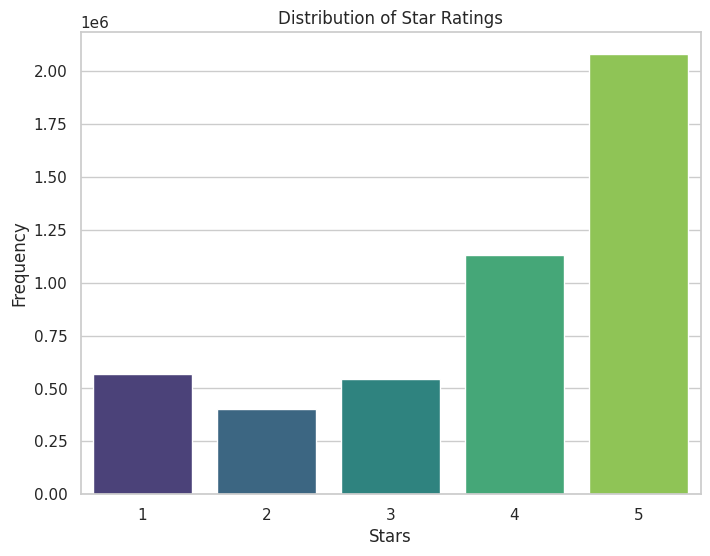

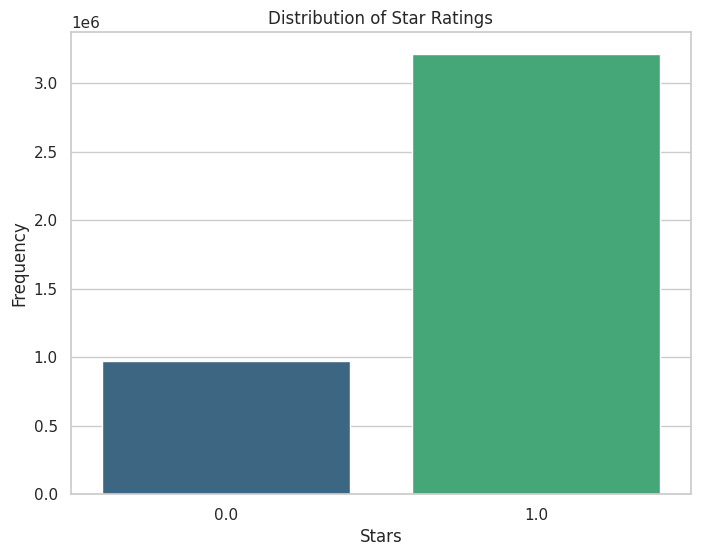

In [8]:
plot_rating_distribution(restaurant_reviews_df, column='stars_x')
# Label reviews as positive (4-5 stars) or negative (1-2 stars)
restaurant_reviews_df['label'] = restaurant_reviews_df['stars_x'].apply(lambda x: 1 if x >= 4 else 0 if x <= 2 else np.nan)

# Drop neutral reviews (3 stars) to focus only on positive and negative reviews
restaurant_reviews_df = restaurant_reviews_df.dropna(subset=['label'])

# Show the distribution of positive and negative reviews
plot_rating_distribution(restaurant_reviews_df, column='label')

The distribution of ratings helps us understand the balance of positive and negative reviews and provides insight into general sentiment trends. Above we visualize the distribution of star ratings in restaurant reviews using the plot_rating_distribution function. To understand the qualities associated with good reviews, we filtered the data into positive (4-5 stars) and negative (1-2 stars) categories. This will enable us to focus on highly positive and negative sentiments for further analysis. We found it interesting that users used 2/3 star ratings much less than they did 1, 4, or 5 ratings. Usually reviews our left after an exceptionally good or bad experience, so this may be reflective of that. 

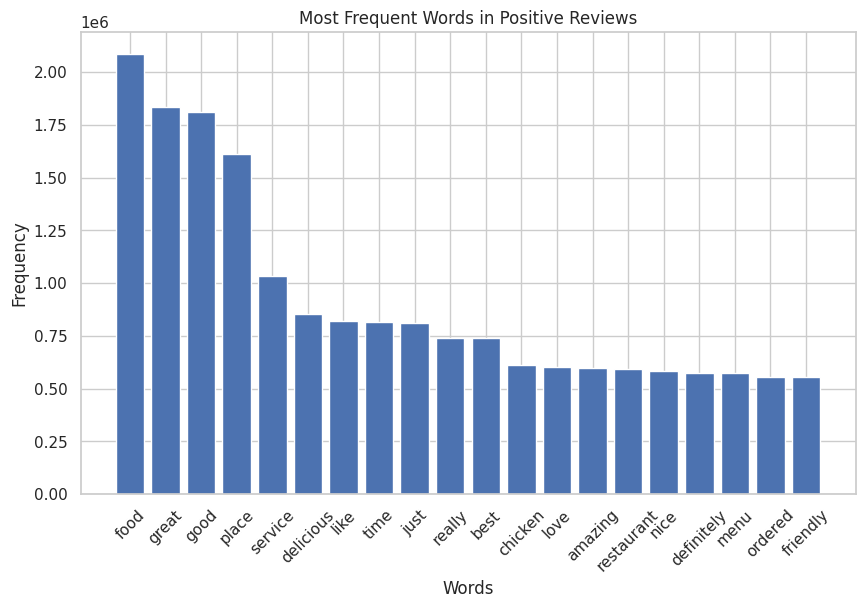

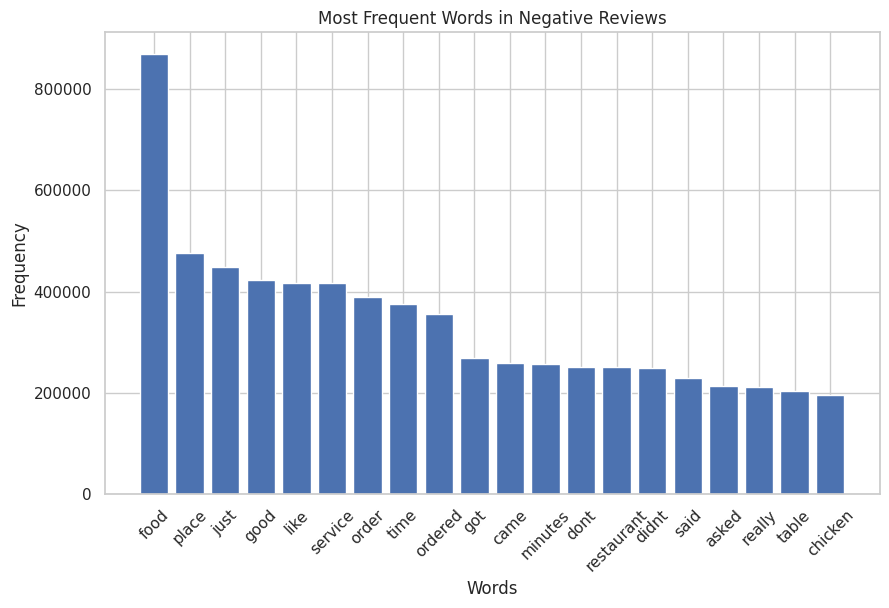

In [9]:
# Further analysis: bar charts to visualize frequent terms in positive and negative reviews
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt

# Plotting most frequest words
def plot_frequent_words(text, title, n=20):
    vectorizer = CountVectorizer(stop_words='english', max_features=n)
    word_matrix = vectorizer.fit_transform(text)
    sum_words = word_matrix.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    
    words, freqs = zip(*words_freq)
    plt.figure(figsize=(10, 6))
    plt.bar(words, freqs)
    plt.title(title)
    plt.xticks(rotation=45)
    plt.xlabel("Words")
    plt.ylabel("Frequency")
    plt.show()

positive_reviews = restaurant_reviews_df[restaurant_reviews_df['label'] == 1]['cleaned_text']
negative_reviews = restaurant_reviews_df[restaurant_reviews_df['label'] == 0]['cleaned_text']

plot_frequent_words(positive_reviews, title="Most Frequent Words in Positive Reviews")
plot_frequent_words(negative_reviews, title="Most Frequent Words in Negative Reviews")


Above we created bar charts to visualize the most frequest words in positive/negative reviews. From these, we can identify themes and qualities that commonly appear in positive and negative reviews, helping answer the question of what makes a review good. We can use this preparation for deeper sentiment analysis.

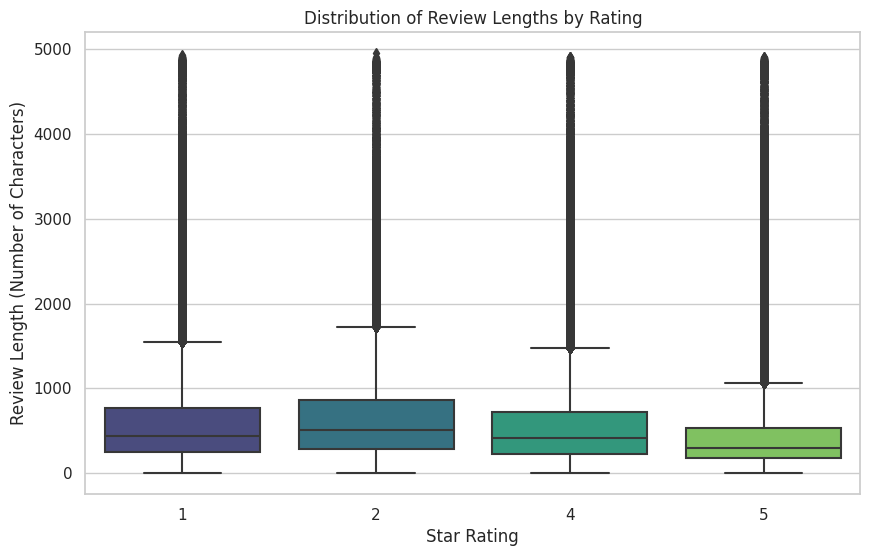

In [10]:
# Ensure the 'review_length' column exists
restaurant_reviews_df['review_length'] = restaurant_reviews_df['cleaned_text'].apply(len)

# Create a boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='stars_x', y='review_length', data=restaurant_reviews_df, palette='viridis')
plt.title('Distribution of Review Lengths by Rating')
plt.xlabel('Star Rating')
plt.ylabel('Review Length (Number of Characters)')
plt.show()


We wanted to understand whether review length has an impact on the review's sentiment, as sometimes if the experience was overwhelmingly bad (or good) that can lead to longer reviews. To us, it felt more probable that longer reviews indicate more negative reviews, as usually one would need to explain why they left a 1 star. To analyze this, we used a boxplot to show the distribution of review lengths for each rating. This revealed that